### `Ali Almalki`

# **Skim Literature (SkimLit) 📜**

## **Project Description:**
In this project, I am going be replicating the deep learning model behind the 2017 paper [*PubMed 200k RCT: a Dataset for Sequenctial Sentence Classification in Medical Abstracts*](https://arxiv.org/abs/1710.06071) and adding further modelling experiments on my own. 

When it was released, the paper presented a new dataset called PubMed 200k RCT which consists of ~200,000 labelled Randomized Controlled Trial (RCT) abstracts.

## **What is RCT?** 

Randomized controlled trials (RCT) are prospective studies that measure the effectiveness of a new intervention or treatment. Although no study is likely on its own to prove causality, randomization reduces bias and provides a rigorous tool to examine cause-effect relationships between an intervention and outcome.

The goal of the dataset was to explore the ability for NLP models to classify sentences which appear in sequential order.

**In other words, given the abstract of a RCT, what role does each sentence serve in the abstract?**

## I am going to do the following:

* Downloading a text dataset ([PubMed RCT200k from GitHub](https://github.com/Franck-Dernoncourt/pubmed-rct))
* Writing a **preprocessing function** to prepare our data for modelling
* Setting up a series of **modelling experiments**
  * Making a baseline (TF-IDF classifier)
  * Deep models with different combinations of: token embeddings, character embeddings, pretrained embeddings, positional embeddings
* Building our first multimodal model (taking multiple types of data inputs)
  * Replicating the model architecture from https://arxiv.org/pdf/1612.05251.pdf 
* Find the most wrong predictions
* Making predictions on PubMed abstracts from the wild

In [120]:
# Import all required libraries 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

import tensorflow as tf
import tensorflow_hub as hub # TensorFlow Hub
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.utils import plot_model

import os
import random
import string

In [55]:
# Check for GPU availability 
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-d1474cc6-c386-a9b7-0759-b24e2221c763)


### 1) Download the PubMed 200k RCT dataset.

In [56]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git

fatal: destination path 'pubmed-rct' already exists and is not an empty directory.


In [57]:
!ls pubmed-rct

PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md




![This is a sample of how the data looks like:](https://drive.google.com/file/d/1qKO51_B56TI1UlU3pJnm8rRZfgLPDT6c/view?usp=sharing)


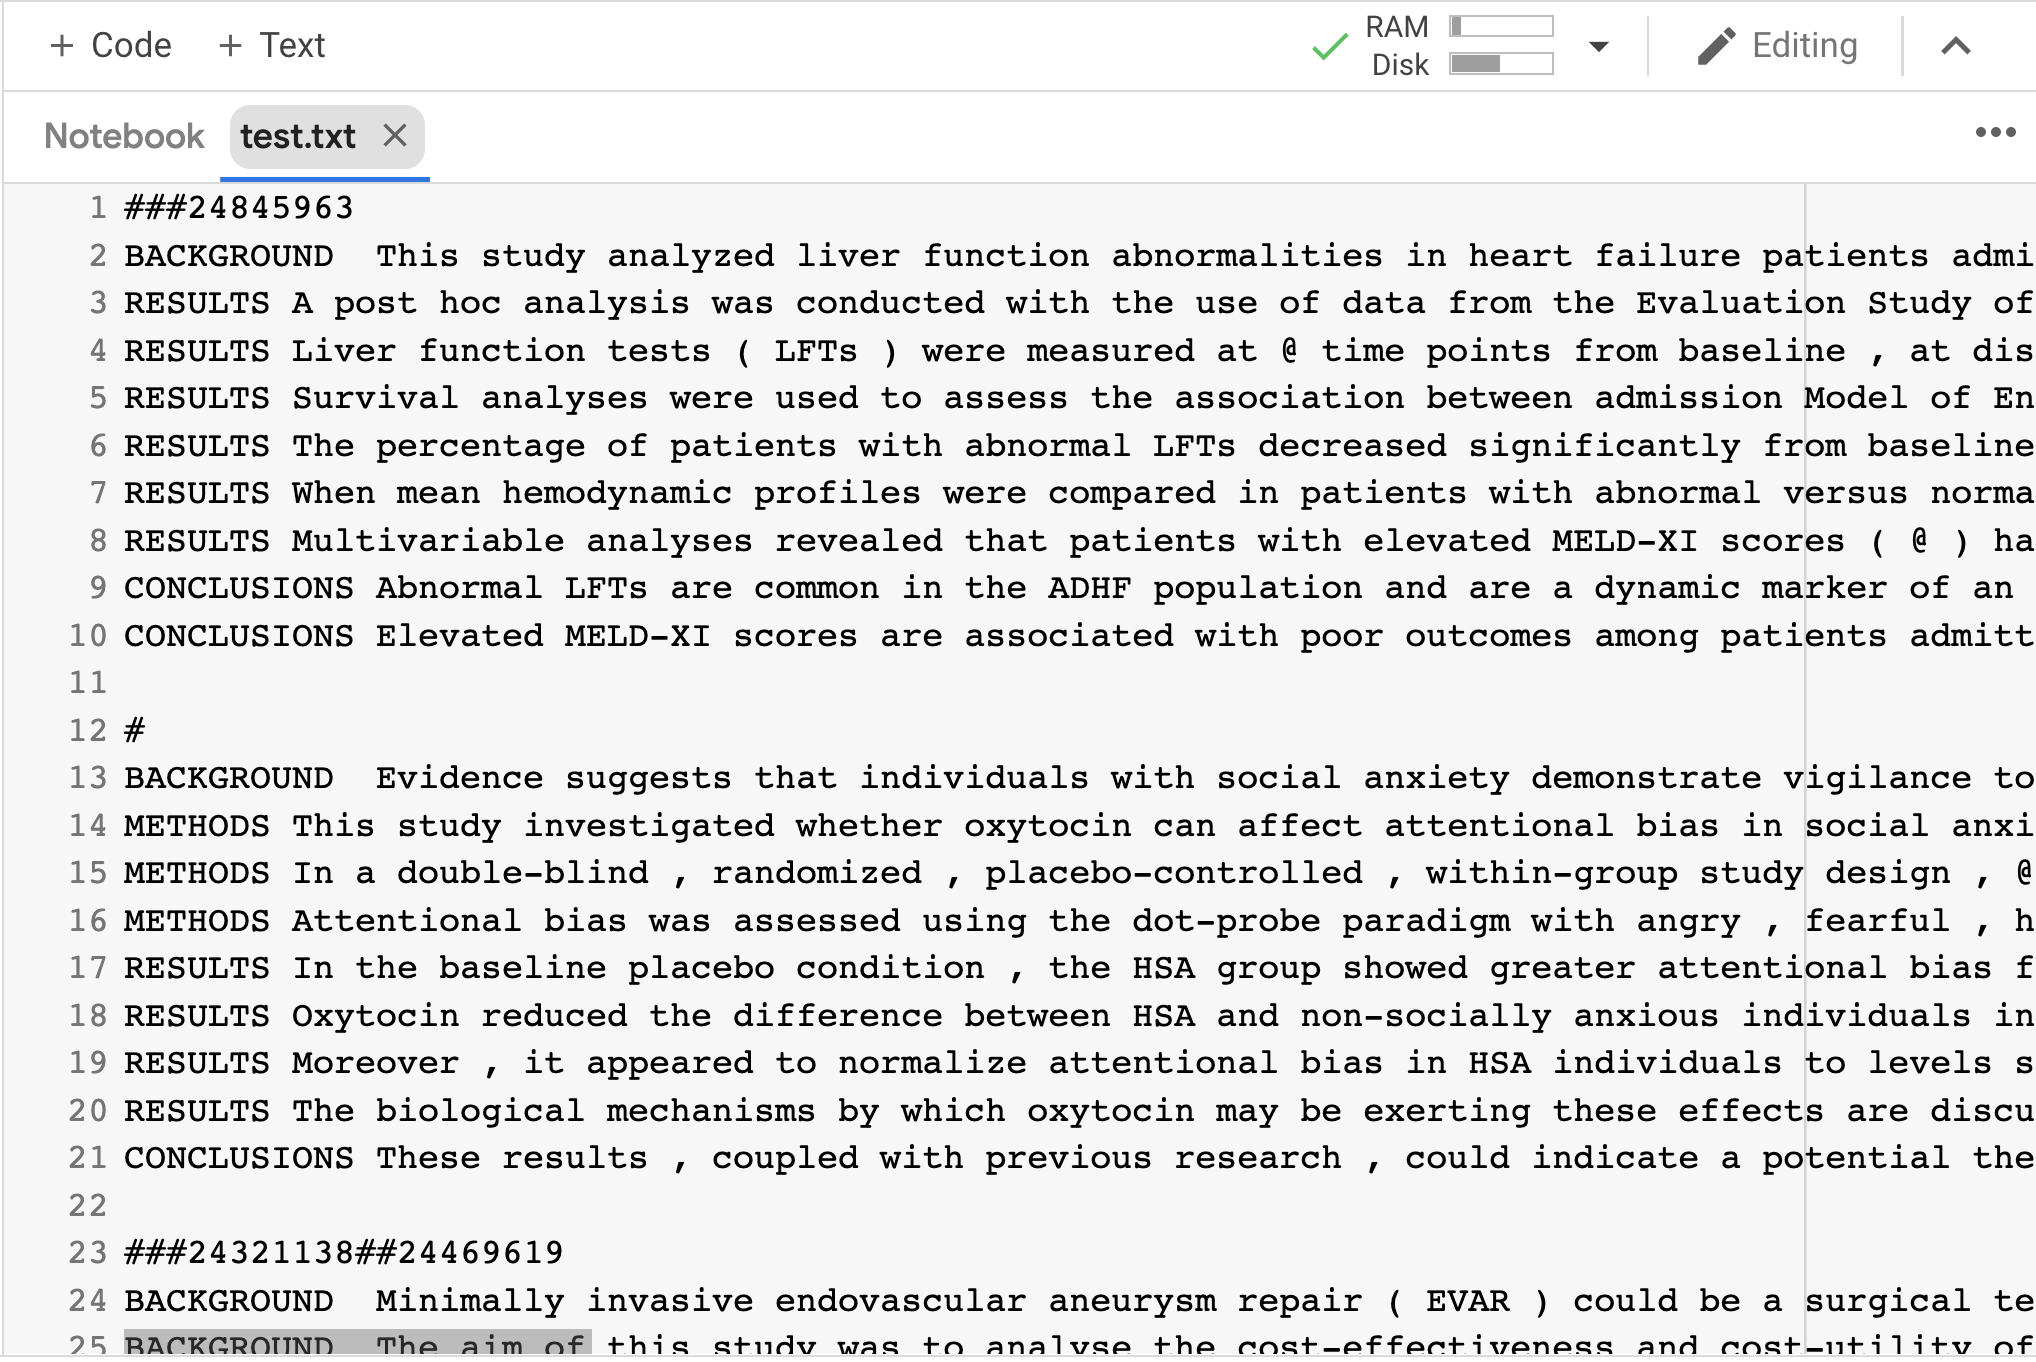
*The data contains many abstracts with the following labels: BACKGROUND, OBJECTIVE, METHODS, RESULTS, CONCLUSION.*

Ok, so to begin with, the dataset I am going to be focused on is 

* `PubMed_20k_RCT_numbers_replaced_with_at_sign`.

Why this one?

Rather than working with the whole 200k dataset, I will keep my experiments quick by starting with a smaller subset. 

In [58]:
# Let's check the file contents
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/

dev.txt  test.txt  train.txt


In [59]:
# Save the filepath to our directory in a variable (data_dir)
data_dir = "pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"
print(f"The path: {data_dir}")
print(f"The filenames in the target directory are the following: {os.listdir(data_dir)}")

The path: pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/
The filenames in the target directory are the following: ['train.txt', 'dev.txt', 'test.txt']


### 2) Data Preprocessing

First, let's try to have a look on our data contents.

**Function#1:** I will write a function `read_lines(filename)` to read the lines of a given document

In [60]:
# Create a function to read the lines of a document 
def read_lines(filename):
  """
  This function reads a filename (file path) which is a text file and returns the lines of text as a list. 

  Args: 
  filename: a string containing the target filepath to read from it. 

  Returns:
  A list of strings with one string per line from the target filename path. 

  For example: 
  ["This is the first line of the filename"]
  ["This is the second line of the filename"]
  ["This is the third line of the filename"]
  and so on...
  """

  with open(filename, "r") as filename:
    return filename.readlines() 

Now let's use the function `get_lines()` which takes the filepath of a text file, opens it, reads each of the lines and returns them.

Let's try it out on the training data (`train.txt`).

In [61]:
# Check data_dir again 
print(data_dir)

pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/


In [62]:
# Read the lines in the train.txt folder
train_lines = read_lines(data_dir + "train.txt")
print(train_lines[:10]) # the whole first example of an abstract

['###24293578\n', 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n', 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n', 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n', 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n', 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n', 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and high-s

Ok, Now let's write a function to perform the following steps:

* Take a target file of abstract samples.
* Read the lines in the target file.
* For each line in the target file:  
  * If the line begins with `###` mark it as an abstract ID and the beginning of a new abstract.
    * Keep count of the number of lines in a sample.
  * If the line begins with `\n` mark it as the end of an abstract sample.
    * Keep count of the total lines in a sample.
  * Record the text before the `\t` as the label of the line.
  * Record the text after the `\t` as the text of the line.
* Return all of the lines in the target text file as a list of dictionaries containing the key/value pairs:
  * `"line_number"` - the position of the line in the abstract (e.g. `3`).
  * `"target"` - the role of the line in the abstract (e.g. `OBJECTIVE`).
  * `"text"` - the text of the line in the abstract.
  * `"total_lines"` - the total lines in an abstract sample (e.g. `14`).
* Abstract ID's and newlines should be omitted from the returned preprocessed data.

Example returned preprocessed sample (a single line from an abstract):

```
[{'line_number': 0,
  'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'total_lines': 11},
  ...]
```

**Function#2:** I will write a function `preprocess_text_with_line_numbers(filename)` to return a list of dictionaries of abstract line data.

In [63]:
def preprocess_text_with_line_numbers(filename):
  """
  This function returns a list of dictionaries of abstract line data.

  Takes in filename (file path), reads its contents and sorts through each line,
  extracting things like the target label, the text of the sentence,
  how many sentences are in the current abstract and what sentence number
  the target line is.

  Args:
      filename: a string of the target text file to read and extract line data
      from.
  
  Returns:
      A list of dictionaries each containing a line from an abstract,
      the lines label, the lines position in the abstract and the total number
      of lines in the abstract where the line is from. For example:

      [{"target": 'CONCLUSION',
        "text": The study couldn't have gone better, turns out people are kinder than you think",
        "line_number": 8,
        "total_lines": 8}]

  """

  input_lines = read_lines(filename) # read all lines from filename 
  abstract_lines = "" # create an empty abstract 
  abstract_samples = [] # create an empty list of abstracts

  # Loop through each line in the target file 

  for line in input_lines:
    if line.startswith("###"):
      abstract_id = line
      abstract_lines = "" # reset abstract string
    elif line.isspace(): # check to see if line is a new line
      abstract_line_split = abstract_lines.splitlines() # split abstract into separate lines

      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} # create empty dict to store data from line 
        target_text_split = abstract_line.split("\t") # split target label from text 
        line_data["target"] = target_text_split[0] # get target label 
        line_data["text"] = target_text_split[1].lower() # get target text and lower it 
        line_data["line_number"] = abstract_line_number # put the number line that appears in the abstract 
        line_data["total_lines"] = len(abstract_line_split) - 1 # put total lines that are in the abstract
        abstract_samples.append(line_data) # add line data to abstract samples list 

    else:
      abstract_lines += line


  return abstract_samples  # return abstract samples list contains dictionaries each containing a line from an abstract
    


Ok, now let's use `preprocess_text_with_line_numbers(filename)` funciton to preprocess each of our RCT 20k datasets.

In [64]:
# Get data from file and preprocess it 
train_samples = preprocess_text_with_line_numbers(data_dir + "train.txt")
dev_samples = preprocess_text_with_line_numbers(data_dir + "dev.txt")
test_samples = preprocess_text_with_line_numbers(data_dir + "test.txt")

# Check each data set lenght
print(len(train_samples))
print(len(dev_samples))
print(len(test_samples))

180040
30212
30135


In [65]:
# Let's have a look on our training data 
train_samples[:20]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

Perfect! Looks like our `preprocess_text_with_line_numbers()` function worked well. 

Now, Turn our list of dictionaries into pandas DataFrame to visualise them better.

In [66]:
# Create dataframes for train, dev and test sets

train_df = pd.DataFrame(train_samples)
dev_df = pd.DataFrame(dev_samples)
test_df = pd.DataFrame(test_samples)

# Check the length of each set 
print(len(train_df))
print(len(dev_df))
print(len(test_df))

180040
30212
30135


In [67]:
# Have a look on the training dataframe 
train_df.head(20)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


Beautiful!!

### 3) Exploratory Data Analysis (EDA)

In [68]:
# Check the label (target) distribution in the training set 
print(train_df.target.value_counts())

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64


Ok, looks like sentences with the `OBJECTIVE` label are the least common👆🏻


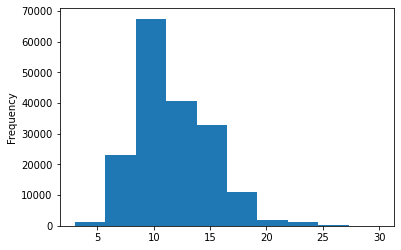

In [69]:
# Visualise the the distribution of the abstract lengths in the training set 
train_df.total_lines.plot.hist();

Another observation, looks like most of the abstracts are around `7 to 15` sentences in length.

### Get lists of sentences

When we build our deep learning model, one of its main inputs will be a list of strings (the lines of an abstract).

We can get these easily from our DataFrames by calling the `tolist()` method on our `"text"` columns.

In [70]:
# Check the training set again 
train_df.head()
print(train_df.shape)
print(dev_df.shape)
print(test_df.shape)

(180040, 4)
(30212, 4)
(30135, 4)


In [71]:
# Convert abstract text lines into a list 

train_sentences = train_df["text"].to_list()
dev_sentences = dev_df["text"].to_list()
test_sentences = test_df["text"].to_list()

print(len(train_sentences))
print(len(dev_sentences))
print(len(test_sentences))

180040
30212
30135


In [72]:
# View first 20 lines of training sentences 
train_sentences[:20]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

### Create numeric labels

Here I will use Scikit-Learn's [`OneHotEncoder`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) and [`LabelEncoder`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html) classes.

The labels we have are the following: 
* BACKGROUND
* OBJECTIVE
* METHODS
* RESULTS
* CONCLUSION

In [73]:
# Check the dataset labels 
train_df.target.unique()

array(['OBJECTIVE', 'METHODS', 'RESULTS', 'CONCLUSIONS', 'BACKGROUND'],
      dtype=object)

In [74]:
# One-hot encode previous labels 

one_hot_encoder = OneHotEncoder(sparse=False) # non-sparse matrix
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
dev_labels_one_hot = one_hot_encoder.fit_transform(dev_df["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.fit_transform(test_df["target"].to_numpy().reshape(-1, 1))

# Check what each set labels look like 
print("Training Set Labels and Shape\n")
print(train_labels_one_hot)
print(train_labels_one_hot.shape, "\n")
print("Dev Set Labels and Shape\n")
print(dev_labels_one_hot)
print(dev_labels_one_hot.shape, "\n")
print("Test Set Labels and Shape\n")
print(test_labels_one_hot)
print(test_labels_one_hot.shape, "\n")

Training Set Labels and Shape

[[0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 ...
 [0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]]
(180040, 5) 

Dev Set Labels and Shape

[[1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 ...
 [0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]]
(30212, 5) 

Test Set Labels and Shape

[[1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 ...
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]]
(30135, 5) 



In [75]:
# Extract labels ("target" columns) and encode them into integers 

label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
dev_labels_encoded = label_encoder.fit_transform(dev_df["target"].to_numpy())
test_labels_encoded = label_encoder.fit_transform(test_df["target"].to_numpy())

# Check what each set labels look like 
print("Training Set Labels and Shape\n")
print(train_labels_encoded)
print(train_labels_encoded.shape, "\n")
print("Dev Set Labels and Shape\n")
print(dev_labels_encoded)
print(dev_labels_encoded.shape, "\n")
print("Test Set Labels and Shape\n")
print(test_labels_encoded)
print(test_labels_encoded.shape, "\n")

Training Set Labels and Shape

[3 2 2 ... 4 1 1]
(180040,) 

Dev Set Labels and Shape

[0 0 3 ... 4 1 1]
(30212,) 

Test Set Labels and Shape

[0 4 4 ... 4 4 1]
(30135,) 



In [76]:
# Display class names and number of classes from `LabelEncoder` instance 
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_

# Check class names and number of classes 
print(f"Number of classes: {num_classes}")
print(f"Class names are the following: {class_names}")

Number of classes: 5
Class names are the following: ['BACKGROUND' 'CONCLUSIONS' 'METHODS' 'OBJECTIVE' 'RESULTS']


### Modelling Part 👨🏻‍💻 (My Favourite Part 😉)

Now it's time to setup a series of modelling experiments.

I will start by creating a simple baseline model to obtain a score to try to beat by building more and more complex models as I move towards replicating the sequence model outlined in [*Neural networks for joint sentence
classification in medical paper abstracts*](https://arxiv.org/pdf/1612.05251.pdf).

For each model, I will train it on the training data and evaluate it on the dev (validation) data.

I will be running the following series of experiemnts:

* **Model 0**: TF-IDF Multinomial Naive Bayes (baseline)
* **Model 1**: TF-IDF Linear Support Vector Classification (SVC) 
* **Model 2**: Conv1D with token embeddings
* **Model 3**: Feature extraction with pretrained token embeddings
* **Model 4**: 
* **Model 5**: 
* **Model 6**: 
* **Model 7**:

Model 0 is the simplest to acquire a baseline which we'll expect each other of the other deeper models to beat.

Each experiment will go through the following steps:
* Construct the model
* Train the model
* Make predictions with the model
* Track prediction evaluation metrics for later comparison


### **Model 0**: TF-IDF Multinomial Naive Bayes (baseline)

In [24]:
train_sentences[:5]
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [25]:
# Create a pipeline 
model_0 = Pipeline([
    ("tf-idf", TfidfVectorizer()),
    ("clf", MultinomialNB())
])

# Fit the pipeline to the training set 
model_0.fit(X=train_sentences, 
            y=train_labels_encoded)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

### **Model 0**: Evaluation

In [26]:
# Evaluate model_0 (baseline model) on the dev set
model_0.score(X=dev_sentences, 
              y=dev_labels_encoded)

0.7218323844829869

Nice! Looks like `72.2%` accuracy will be the number to beat with our deeper models.

### **Model 0**: Make Predictions

In [27]:
# Make predictions 
baseline_preds = model_0.predict(dev_sentences)

print(baseline_preds)
print(baseline_preds.shape)

[4 1 3 ... 4 4 1]
(30212,)


To evaluate our baseline model predictions I am going to write a function called `calculate_results()`
to obtain the following:

* Accuracy
* Precision
* Recall
* F1-score

In [28]:
def calculate_results(y_true, y_pred):
  """
  This function calculates model accuracy, precision, recall and f1-score 
  of a classification model.

  Args:
      y_true: true labels in the form of a 1D array
      y_pred: predicted labels in the form of a 1D array

  Returns a dictionary of accuracy, precision, recall, f1-score.
  """
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall and f1 score using weighted average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
  model_results = {'accuracy': model_accuracy,
                  'precision': model_precision,
                  'recall': model_recall,
                  'f1': model_f1}
  return model_results

### **Model 0**: Model Results (Accuracy, Precision, Recall, F1-Score)

In [29]:
# Calculate model_0 (baseline model) results 
baseline_results = calculate_results(y_true=dev_labels_encoded, 
                                     y_pred=baseline_preds)
print(baseline_results)

{'accuracy': 72.1832384482987, 'precision': 0.7186466952323352, 'recall': 0.7218323844829869, 'f1': 0.6989250353450294}


Ok, since Linear Support Vector Machine is widely regarded as one of the best text classification algorithms, I am going to train it on our data 

and see how it goes. 

📝 **Note:** Since Support Vector Machines (SVMs) takes ages to train a large dataset, I will be using Linear Support Vector Classification (SVC) because it is more suitable for a large dataset than SVMs

### **Model 1**: TF-IDF Linear Support Vector Classification (SVC)

In [30]:
# Create a pipeline 
model_1 = Pipeline([
    ("tf-idf", TfidfVectorizer()),
    ("svc", LinearSVC())
])

# Fit the pipeline to the training set 
model_1.fit(X=train_sentences, 
            y=train_labels_encoded)


Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('svc', LinearSVC())])

### **Model 1**: Evaluation

In [31]:
# Evaluate model_1 on the dev set
model_1.score(X=dev_sentences, 
              y=dev_labels_encoded)

0.7888256321991262

In [32]:
# Compare between baseline model (model_0) and (model_1) performance 
print(f"**Model 0**: TF-IDF Multinomial Naive Bayes (baseline) Accuracy Score: {model_0.score(X=dev_sentences,  y=dev_labels_encoded)* 100:.2f}%")
print(f"**Model 1**: TF-IDF Linear Support Vector Classification (SVC) Accuracy Score: {model_1.score(X=dev_sentences, y=dev_labels_encoded)* 100:.2f}%")

**Model 0**: TF-IDF Multinomial Naive Bayes (baseline) Accuracy Score: 72.18%
**Model 1**: TF-IDF Linear Support Vector Classification (SVC) Accuracy Score: 78.88%


Looks like I am making progress here!😍

I have achieved better performance with model_1 `78.88%` than baseline model `72.18%`

### **Model 1**: Make Predictions

In [33]:
# Make predictions 
model_1_preds = model_1.predict(dev_sentences)

print(model_1_preds)
print(model_1_preds.shape)

[0 0 3 ... 4 1 1]
(30212,)


### **Model 1**: Model Results (Accuracy, Precision, Recall, F1-Score)

In [34]:
# Calculate model_1 results 
model_1_results = calculate_results(y_true=dev_labels_encoded, 
                                     y_pred=model_1_preds)
print(model_1_results)

{'accuracy': 78.88256321991261, 'precision': 0.7844288448687128, 'recall': 0.7888256321991262, 'f1': 0.7856518139245262}


### **Model 2**: Conv1D with token embeddings (Data Preprocessing )

In [148]:
# Let's remember how our data looks like

print(train_sentences[:5])
print(train_labels_encoded[:5])

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .', 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .', 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .', 'pain was assessed using the visual analog pain scale ( @-@ mm ) .', 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .']
[3 2 2 2 2]


### Encoding `training sentences` into numbers

The model works best when all the sentences have the same length (this is important for creating batches of the same size tensors).

For example, if one sentence is eight words long and another is 29 words long, we want to pad the eight word sentence with zeros so it ends up being the same length as the 29 word sentence.

 

In [149]:
# Find the average length of sentences in the training set

sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)

print(avg_sent_len)  # average sentence length (in tokens)

26.338269273494777


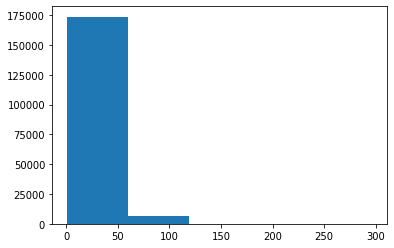

In [150]:
# Distribution of sentences length 
plt.hist(sent_lens, bins=5);

From the above histogram figure we can notice that the vast majority of sentences are between `0 and 50` tokens in length.

In [151]:
# How long of a sentence covers 95% of the lengths?

output_seq_len = int(np.percentile(sent_lens, 95))

print(output_seq_len)

55


Ok, it looks like 95% of the sentences in our training set have a length of 55 tokens or less.

When we create our tokenization layer, we'll use this value to turn all of our sentences into the same length. Meaning sentences with a length below 55 get padded with zeros and sentences with a length above 55 get truncated (words after 55 get cut off).

In [152]:
sent_lens[:5] # Sentences length

[49, 27, 15, 14, 35]

In [153]:
# Find out the maximum and minimum sentence length in the training set
print(max(sent_lens))
print(min(sent_lens))

296
1


### Create Text Vectorizer to Encode `training sentences` into numbers

`max_tokens` (the number of unique words in our dataset) 

 `output_sequence_length` (our desired output length for each vectorized sentence).

* Section 3.2 of the [PubMed 200k RCT paper](https://arxiv.org/pdf/1710.06071.pdf) states the vocabulary size of the PubMed 20k dataset as 68,000. So we'll use that as our `max_tokens` parameter.

* Also, since discovered a sentence length of 55 covers 95% of the training sentences, we'll use that as our `output_sequence_length` parameter.

In [154]:
# How many words are in the vocabulary?
max_tokens = 68000

In [155]:
text_vectorizer = TextVectorization(max_tokens = max_tokens, # 68000, number of words in vocabulary
                                    output_sequence_length = 55)  # desired output length of vectorized sequences

print(text_vectorizer)

In [156]:
# Adapt text_vectorizer to our training sentences
text_vectorizer.adapt(train_sentences)

In [157]:
# Test the text vectorizer

target_sentence = random.choice(train_sentences)
print(f"Text: \n {target_sentence}")
print(f"\n Length of text: \n {len(target_sentence.split())}")
print(f"\n Vectorized text: \n {text_vectorizer([target_sentence])}")


Text: 
 after stroke , pneumonia is a relevant medical complication that can be precipitated by aspiration of saliva , liquids , or solid food .

 Length of text: 
 24

 Vectorized text: 
 [[   21   276  1445    20     8   963   274  1101    28   171    36 29137
     22  2175     4  3465 13194    16  2603   661     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]


We can notice from above `Vectorized text` that sequences (sentences) less than 55 in length get padded with zeros.

In [158]:
# How many words in our training vocabulary?

rct_20k_text_vocab = text_vectorizer.get_vocabulary()

print(f"Number of words in vocabulary: {len(rct_20k_text_vocab)}")
print(f"Most common words in the vocabulary: {rct_20k_text_vocab[:5]}")
print(f"Least common words in the vocabulary: {rct_20k_text_vocab[-5:]}")

Number of words in vocabulary: 64841
Most common words in the vocabulary: ['', '[UNK]', 'the', 'and', 'of']
Least common words in the vocabulary: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [159]:
# Get the configuration of text_vectorizer 
text_vectorizer.get_config()

{'name': 'text_vectorization_2',
 'trainable': True,
 'batch_input_shape': (None,),
 'dtype': 'string',
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None}

### Create Text Embedding Layer

To create a richer numerical representation of our text, we can use an **embedding**.

As our model learns (by going through many different examples of abstract sentences and their labels), it'll update its embedding to better represent the relationships between tokens in our corpus.

We can create a trainable embedding layer using TensorFlow's [`Embedding`](https://www.tensorflow.org/tutorials/text/word_embeddings) layer.

Once again, the main parameters we're concerned with here are the inputs and outputs of our `Embedding` layer.

The `input_dim` parameter defines the size of our vocabulary. And the `output_dim` parameter defines the dimension of the embedding output.

Once created, our embedding layer will take the integer outputs of our `text_vectorization` layer as inputs and convert them to feature vectors of size `output_dim`.


In [160]:
# Create token embedding layer 

token_embed = layers.Embedding(input_dim=len(rct_20k_text_vocab), # length of vocabulary
                               output_dim=128,
                               mask_zero=True, 
                               name="token_embedding")
print(token_embed)

In [161]:
# Test our text embedding layer 
print(f"Sentence before vectorization:\n{target_sentence}\n")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"Sentence after vectorization (before embedding):\n{vectorized_sentence}\n")
embedded_sentence = token_embed(vectorized_sentence)
print(f"Sentence after embedding:\n{embedded_sentence}\n")
print(f"Embedded sentence shape: {embedded_sentence.shape}")

Sentence before vectorization:
after stroke , pneumonia is a relevant medical complication that can be precipitated by aspiration of saliva , liquids , or solid food .

Sentence after vectorization (before embedding):
[[   21   276  1445    20     8   963   274  1101    28   171    36 29137
     22  2175     4  3465 13194    16  2603   661     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]

Sentence after embedding:
[[[ 0.00835069  0.0145375   0.01859189 ...  0.03663028 -0.04813788
    0.04357261]
  [-0.00951731 -0.03767399  0.04371044 ...  0.04959767 -0.03499715
   -0.00245234]
  [ 0.0269464  -0.03829835  0.02352977 ...  0.00827282  0.0194726
    0.03317991]
  ...
  [ 0.01345059 -0.03578293 -0.01992079 ...  0.00825335 -0.00676004
    0.00122754]
  [ 0.01345059 -0.03578293 -0.01992079 ...  0.00825335 -0.00676004
    0.001

### Create Datasets

The main steps we'll want to use with our data is to turn it into a `PrefetchDataset` of batches.

Doing so we'll ensure TensorFlow loads our data onto the GPU as fast as possible, in turn leading to faster training time.

To create a batched `PrefetchDataset` we can use the methods [`batch()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#batch) and [`prefetch()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#prefetch), the parameter [`tf.data.AUTOTUNE`](https://www.tensorflow.org/api_docs/python/tf/data#AUTOTUNE) will also allow TensorFlow to determine the optimal amount of compute to use to prepare datasets.

In [162]:
# Turn our existing data into TensorFlow Datasets

train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
dev_dataset = tf.data.Dataset.from_tensor_slices((dev_sentences, dev_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

# Check out datasets shapes 
print(len(train_dataset))
print(len(dev_dataset))
print(len(test_dataset))

# Check out the training set 
print(train_dataset) # should be a TensorSliceDataset

180040
30212
30135
<TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>


In [163]:
# Take the TensorSliceDataset's and turn them into prefetched batches

train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
dev_dataset = dev_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Check out datasets shapes 
print(len(train_dataset))
print(len(dev_dataset))
print(len(test_dataset))

# Check out the training set 
print(train_dataset) # should be a PrefetchDataset now

5627
945
942
<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>


### **Model 2**: Conv1D with token embeddings

All of our deep learning models will follow a similar structure:

```
Input (text) -> Tokenize -> Embedding -> Layers -> Output (label probability)
```

The workflow will be as follows:
- Build model
- Train model
- Evaluate model (make predictions and compare to ground truth)

In [164]:
# Build the model - Conv1D

inputs = layers.Input(shape=(1, ), dtype=tf.string) # Input (text), Take the text first (train_sentences)
text_vectors = text_vectorizer(inputs) # Tokenize, Turn the text into numbers
token_embeddings = token_embed(text_vectors) # Create embedding - find the relationship between words

# Layers Part 

x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(token_embeddings)
x = layers.GlobalAveragePooling1D()(x) # condense the output of our feature vector

# Output (label probability)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_2 = tf.keras.Model(inputs, outputs)

# Compile the model 
model_2.compile(loss="categorical_crossentropy", # our labels are  one hot encoded. If our labels are integers then we use `sparse_categorical_crossentropy`
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [165]:
# Get summary of Conv1D model (model_2)
model_2.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_2 (TextV  (None, 55)               0         
 ectorization)                                                   
                                                                 
 token_embedding (Embedding)  (None, 55, 128)          8299648   
                                                                 
 conv1d_1 (Conv1D)           (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense_8 (Dense)             (None, 5)                 325 

### Fit the model 

Since our training data contains nearly 200,000 sentences, fitting a deep model may take a while even with a GPU. So to keep our experiments swift, we're going to run them on a subset of the training dataset.

More specifically, we'll only use the first 20% of batches (about 36,000 samples) of the training set to train on and the first 20% of batches from the dev set to validate on.

In [166]:
# Fit the model 
model_2_history = model_2.fit(train_dataset,
                              steps_per_epoch=int(0.2 * len(train_dataset)), # only fit on 20% of batches for faster training time
                              epochs=5,
                              validation_data=dev_dataset,
                              validation_steps=int(0.2 * len(dev_dataset))) # only validate on 20% of batches

Epoch 1/5
1125/1125 [==============================] - 11s 9ms/step - loss: 0.7845 - accuracy: 0.6996 - val_loss: 0.6229 - val_accuracy: 0.7746
Epoch 2/5
1125/1125 [==============================] - 10s 9ms/step - loss: 0.5997 - accuracy: 0.7835 - val_loss: 0.5686 - val_accuracy: 0.7976
Epoch 3/5
1125/1125 [==============================] - 10s 9ms/step - loss: 0.5855 - accuracy: 0.7922 - val_loss: 0.5448 - val_accuracy: 0.8089
Epoch 4/5
1125/1125 [==============================] - 10s 9ms/step - loss: 0.5497 - accuracy: 0.8051 - val_loss: 0.5282 - val_accuracy: 0.8127
Epoch 5/5
1125/1125 [==============================] - 10s 9ms/step - loss: 0.5430 - accuracy: 0.8076 - val_loss: 0.5315 - val_accuracy: 0.8092


### **Model 2**: Evaluation

In [167]:
# Evaluate on whole dev dataset (we only validated on 20% of batches during training)
model_2.evaluate(dev_dataset)

945/945 [==============================] - 3s 3ms/step - loss: 0.5338 - accuracy: 0.8095


[0.5337544083595276, 0.8095127940177917]

Whoohoo!!😍
Looks like the performance is better than the previous two experiments with an accuracy score of: `81.40%`! 



### **Model 2**: Make Predictions

In [168]:
# Make predictions (our model outputs prediction probabilities for each class)
model_2_pred_probs = model_2.predict(dev_dataset)
print(model_2_pred_probs)

[[5.61361194e-01 1.00122035e-01 1.00402668e-01 1.81293547e-01
  5.68205863e-02]
 [4.90155578e-01 2.77876109e-01 9.44021624e-03 1.90062895e-01
  3.24652158e-02]
 [1.91519767e-01 5.36179636e-03 9.63083585e-04 8.02089572e-01
  6.59039433e-05]
 ...
 [6.80391850e-06 1.49553656e-04 1.43906591e-03 4.28601561e-06
  9.98400271e-01]
 [9.61961374e-02 4.05209422e-01 1.60208076e-01 5.56740910e-02
  2.82712251e-01]
 [4.19811569e-02 9.35801625e-01 1.76700465e-02 1.27110397e-03
  3.27608571e-03]]


In [169]:
# Convert pred probs to classes
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)
print(model_2_preds)

tf.Tensor([0 0 3 ... 4 1 1], shape=(30212,), dtype=int64)


### **Model 2**: Model Results (Accuracy, Precision, Recall, F1-Score)

In [170]:
# Calculate model_2 results
model_2_results = calculate_results(y_true=dev_labels_encoded,
                                    y_pred=model_2_preds)
print(model_2_results)

{'accuracy': 80.95127763802462, 'precision': 0.8065363295979459, 'recall': 0.8095127763802462, 'f1': 0.8057783075102086}


### **Model 3**: Feature extraction with pretrained token embeddings

Since we're moving towards replicating the model architecture in [*Neural Networks for Joint Sentence Classification
in Medical Paper Abstracts*](https://arxiv.org/pdf/1612.05251.pdf), it mentions they used a [pretrained GloVe embedding](https://nlp.stanford.edu/projects/glove/) as a way to initialise their token embeddings.

To emulate this, let's see what results we can get with the [pretrained Universal Sentence Encoder embeddings from TensorFlow Hub](https://tfhub.dev/google/universal-sentence-encoder/4).

The model structure will look like:

```
Inputs (string) -> Pretrained embeddings from TensorFlow Hub (Universal Sentence Encoder) -> Layers -> Output (prediction probabilities)
```

> 🔑 **Note:** We could use GloVe embeddings as per the paper but since we're working with TensorFlow, we'll use what's available from TensorFlow Hub (GloVe embeddings aren't). We'll save [using pretrained GloVe embeddings](https://keras.io/examples/nlp/pretrained_word_embeddings/) as an extension.


You'll notice the lack of tokenization layer we've used in a previous model. This is because the Universal Sentence Encoder (USE) takes care of tokenization for us.

This type of model is called transfer learning, or more specifically, **feature extraction transfer learning**. In other words, taking the patterns a model has learned elsewhere and applying it to our own problem.


To download the pretrained USE into a layer we can use in our model, we can use the [`hub.KerasLayer`](https://www.tensorflow.org/hub/api_docs/python/hub/KerasLayer) class.

We'll keep the pretrained embeddings frozen (by setting `trainable=False`) and add a trainable couple of layers on the top to tailor the model outputs to our own data.

In [171]:
# Download pretrained TensorFlow Hub USE 
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False, 
                                        name="universal_sentence_encoder")

print(tf_hub_embedding_layer)

OK, now our pretrained USE is downloaded and instantiated as a `hub.KerasLayer` instance, let's test it out on a random sentence.

In [172]:
# Test out the embedding on a random sentence 
random_training_sentence = random.choice(train_sentences)
print(f"Random training sentence:\n{random_training_sentence}\n")
use_embedded_sentence = tf_hub_embedding_layer([random_training_sentence])
print(f"Sentence after embedding:\n{use_embedded_sentence[0][:20]} (truncated output)...\n")
print(f"Length of sentence embedding:\n{len(use_embedded_sentence[0])}")

Random training sentence:
the overall incidence of ssi was @/@ ( @ % ) , without differences between groups ; @ % ssis in the control group versus @ % ssis in the intervention group .

Sentence after embedding:
[ 0.01567514 -0.06321195 -0.0044505  -0.03130656  0.0299752   0.00336826
 -0.02832153 -0.02194265  0.00565142  0.06843421  0.06562626  0.04718341
  0.05506984  0.01593571  0.03979505  0.03056717 -0.00635737  0.00800751
  0.0366818   0.06902155] (truncated output)...

Length of sentence embedding:
512


As shown above, Nice!  the pretrained USE module from TensorFlow Hub takes care of tokenizing our text for us and outputs a `512` dimensional embedding vector.

Now we can create and compile a model using our `tf_hub_embedding_layer`.

Let's remember the model structure that we are going to build 

The model structure will look like:

```
Inputs (string) -> Pretrained embeddings from TensorFlow Hub (Universal Sentence Encoder) -> Layers -> Output (prediction probabilities)
```

In [173]:
# Create (model_3) - feature extractor model using TF Hub layer
inputs = layers.Input(shape=[], dtype=tf.string) # Input(text)
pretrained_embedding = tf_hub_embedding_layer(inputs) # USE embedding layer (tokenize text and create embedding)

# Layers Part 

x = layers.Dense(128, activation="relu")(pretrained_embedding)  # add a fully connected layer on top of the embedding
x = layers.Dense(128, activation="relu")(pretrained_embedding)
x = layers.Dense(128, activation="relu")(pretrained_embedding)

# Output Layer
outputs = layers.Dense(5, activation="softmax")(x)
model_3 = tf.keras.Model(inputs=inputs, 
                         outputs=outputs)

# Compile model_3
model_3.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])


In [174]:
# Get a summary of model_3
model_3.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_sentence_encoder   (None, 512)              256797824 
 (KerasLayer)                                                    
                                                                 
 dense_11 (Dense)            (None, 128)               65664     
                                                                 
 dense_12 (Dense)            (None, 5)                 645       
                                                                 
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


In [175]:
# Fit model_3  
model_3_history = model_3.fit(train_dataset,
                              steps_per_epoch=int(0.2 * len(train_dataset)), # only fit on 20% of batches for faster training time
                              epochs=5,
                              validation_data=dev_dataset,
                              validation_steps=int(0.2 * len(dev_dataset))) # only validate on 20% of batches

Epoch 1/5
1125/1125 [==============================] - 16s 13ms/step - loss: 0.8414 - accuracy: 0.6765 - val_loss: 0.7530 - val_accuracy: 0.7083
Epoch 2/5
1125/1125 [==============================] - 14s 12ms/step - loss: 0.7331 - accuracy: 0.7185 - val_loss: 0.7117 - val_accuracy: 0.7295
Epoch 3/5
1125/1125 [==============================] - 14s 13ms/step - loss: 0.7196 - accuracy: 0.7234 - val_loss: 0.6785 - val_accuracy: 0.7388
Epoch 4/5
1125/1125 [==============================] - 14s 12ms/step - loss: 0.6771 - accuracy: 0.7436 - val_loss: 0.6566 - val_accuracy: 0.7465
Epoch 5/5
1125/1125 [==============================] - 14s 12ms/step - loss: 0.6672 - accuracy: 0.7458 - val_loss: 0.6499 - val_accuracy: 0.7531


### **Model 3**: Evaluation

In [176]:
# Evaluate model_3
model_3.evaluate(dev_dataset)

945/945 [==============================] - 10s 11ms/step - loss: 0.6535 - accuracy: 0.7519


[0.6534863114356995, 0.7518866658210754]

### **Model 3**: Make Predictions

In [177]:
# Make predictions with model_3
model_3_pred_probs = model_3.predict(dev_dataset)
print(model_3_pred_probs)

[[3.5337442e-01 5.4566407e-01 5.2362337e-04 9.4077706e-02 6.3602473e-03]
 [3.7310746e-01 5.4530585e-01 1.6517274e-03 7.9143107e-02 7.9182372e-04]
 [4.9463272e-01 3.9567824e-02 1.6505899e-02 4.0711734e-01 4.2176262e-02]
 ...
 [5.0873682e-04 5.6813401e-04 1.2811135e-02 1.5412467e-04 9.8595780e-01]
 [5.4893149e-03 5.9929669e-02 2.7902418e-01 1.5436688e-03 6.5401316e-01]
 [6.1537452e-02 8.0343026e-01 1.2584983e-01 1.2787778e-03 7.9036793e-03]]


In [178]:
# Convert the predictions with model_3 to classes
model_3_preds = tf.argmax(model_3_pred_probs, axis=1)
model_3_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 1, 0, ..., 4, 4, 1])>

### **Model 3**: Model Results (Accuracy, Precision, Recall, F1-Score)

In [179]:
# Calculate results of model_3 results on dec vet
model_3_results = calculate_results(y_true=dev_labels_encoded,
                                    y_pred=model_3_preds)
model_3_results

{'accuracy': 75.18866675493182,
 'precision': 0.7470894453912547,
 'recall': 0.7518866675493181,
 'f1': 0.7469643236717696}

### **Model 4**: Conv1D with character embeddings

The difference between a character and token embedding is that the **character embedding** is created using sequences split into characters (e.g. `hello` -> [`h`, `e`, `l`, `l`, `o`]) where as a **token embedding** is created on sequences split into tokens.

We can create a character-level embedding by first vectorizing our sequences (after they've been split into characters) using the [`TextVectorization`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/TextVectorization) class and then passing those vectorized sequences through an [`Embedding`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding) layer.

Before we can vectorize our sequences on a character-level we'll need to split them into characters. Let's write a function to do so.


In [51]:
# Create a function to split sentences into characters 
def split_chars(text):
  return " ".join(list(text))


In [88]:
# Test above function
split_chars(random_training_sentence)

't h e   i m p a c t   o f   p h a r m a c e u t i c a l   c a r e   o n   n o n - a d h e r e n c e   a n d   h o s p i t a l i s a t i o n   w a s   a n a l y s e d   b y   @   @   t a b l e s   ,   a n d   m o r t a l i t y   b y   c o x   r e g r e s s i o n   .'

### Create character-level datasets by splitting our sequence datasets into characters.

In [98]:
# Split sequence-level data splits into character-level data splits
train_chars = [split_chars(sentence) for sentence in train_sentences]
dev_chars = [split_chars(sentence) for sentence in dev_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]

print(len(train_chars))
print(len(dev_chars))
print(len(test_chars))
print(train_chars[0])

180040
30212
30135
t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .


In [99]:
# What's the average character length?
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len

149.3662574983337

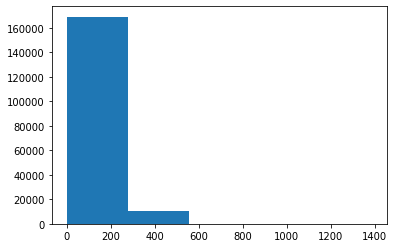

In [100]:
# Check the distribution of our sequences at character-level
plt.hist(char_lens, bins=5);

From the figure above we can notice that most of our sequences are between `0 and 200` characters long.

In [101]:
# Find what character length covers 95% of sequences
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len # 290 - we'll use that in our `TextVectorization` layer as the `output_sequence_length` parameter.

# We'll set `max_tokens` (the total number of different characters in our sequences) to 28, in other words, 26 letters of the alphabet + space + OOV (out of vocabulary or unknown) tokens.

290

In [102]:
# Get all keyboard characters for char-level embedding
alphabet = string.ascii_lowercase + string.digits + string.punctuation 
print(alphabet)

abcdefghijklmnopqrstuvwxyz0123456789!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [103]:
# Create char-level token vectorizer instance
NUM_CHAR_TOKENS = len(alphabet) + 2 # num characters in alphabet + space + OOV token

char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,  
                                    output_sequence_length=output_seq_char_len, # 290
                                    standardize="lower_and_strip_punctuation",
                                    name="char_vectorizer")

print(char_vectorizer)

In [104]:
# Adapt character vectorizer to training characters
char_vectorizer.adapt(train_chars)

In [105]:
# Check character vocabulary characteristics
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in character vocab: {len(char_vocab)}")
print(f"5 most common characters: {char_vocab[:5]}")
print(f"5 least common characters: {char_vocab[-5:]}")

Number of different characters in character vocab: 28
5 most common characters: ['', '[UNK]', 'e', 't', 'i']
5 least common characters: ['k', 'x', 'z', 'q', 'j']


In [106]:
# Test out character vectorizer
random_train_chars = random.choice(train_chars)
print(f"Charified text:\n{random_train_chars}")
print(f"\nLength of chars: {len(random_train_chars.split())}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"\nVectorized chars:\n{vectorized_chars}")
print(f"\nLength of vectorized chars: {len(vectorized_chars[0])}")

Charified text:
t h i r t y - n i n e   p a t i e n t s   c o u l d   b e   a n a l y z e d   ,   @   p a t i e n t s   i n   t h e   i m t - h i   a r m   a n d   @   p a t i e n t s   i n   t h e   i m t - e   a r m   .

Length of chars: 84

Vectorized chars:
[[ 3 13  4  8  3 19  6  4  6  2 14  5  3  4  2  6  3  9 11  7 16 12 10 22
   2  5  6  5 12 19 25  2 10 14  5  3  4  2  6  3  9  4  6  3 13  2  4 15
   3 13  4  5  8 15  5  6 10 14  5  3  4  2  6  3  9  4  6  3 13  2  4 15
   3  2  5  8 15  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  

### Creating a character-level embedding

In [107]:
# Create char embedding layer
char_embed = layers.Embedding(input_dim=NUM_CHAR_TOKENS, # 28 - number of different characters
                              output_dim=25, # embedding dimension of each character (same as Figure 1 in https://arxiv.org/pdf/1612.05251.pdf)
                              mask_zero=False, 
                              name="char_embed")

print(char_embed)

In [108]:
# Test out character embedding layer
print(f"Charified text (before vectorization and embedding):\n{random_train_chars}\n")
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f"Embedded chars (after vectorization and embedding):\n{char_embed_example}\n")
print(f"Character embedding shape: {char_embed_example.shape}")

Charified text (before vectorization and embedding):
t h i r t y - n i n e   p a t i e n t s   c o u l d   b e   a n a l y z e d   ,   @   p a t i e n t s   i n   t h e   i m t - h i   a r m   a n d   @   p a t i e n t s   i n   t h e   i m t - e   a r m   .

Embedded chars (after vectorization and embedding):
[[[-0.00255903 -0.04195322  0.00880734 ...  0.01331477  0.00730599
    0.04654389]
  [ 0.04761578 -0.04678047  0.00956848 ... -0.04727328 -0.0118255
   -0.02002553]
  [-0.00674881  0.0213159  -0.04366812 ... -0.03841     0.03697259
   -0.04728628]
  ...
  [ 0.04472366 -0.01136265 -0.02293184 ... -0.0268157   0.03318299
    0.01089086]
  [ 0.04472366 -0.01136265 -0.02293184 ... -0.0268157   0.03318299
    0.01089086]
  [ 0.04472366 -0.01136265 -0.02293184 ... -0.0268157   0.03318299
    0.01089086]]]

Character embedding shape: (1, 290, 25)


Model structure here will be: 
```
Input (character-level text) -> Tokenize -> Embedding -> Layers (Conv1D, GlobalMaxPool1D) -> Output (label probability)
```

In [109]:
# Create model_4 - Conv1D with character embeddings
inputs = layers.Input(shape=(1,), dtype="string")
char_vectors = char_vectorizer(inputs) # Tokenize
char_embeddings = char_embed(char_vectors) #Character embedding

# Layers
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(char_embeddings)
x = layers.GlobalMaxPool1D()(x)

#Output layer
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_4 = tf.keras.Model(inputs=inputs,
                         outputs=outputs,
                         name="model_4_conv1D_char_embedding")

# Compile model_4
model_4.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [110]:
# Get model_4 summary 
model_4.summary()

Model: "model_4_conv1D_char_embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVector  (None, 290)              0         
 ization)                                                        
                                                                 
 char_embed (Embedding)      (None, 290, 25)           1750      
                                                                 
 conv1d (Conv1D)             (None, 290, 64)           8064      
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 5

In [111]:
# Create char datasets `PrefetchedDataset`
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
dev_char_dataset = tf.data.Dataset.from_tensor_slices((dev_chars, dev_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

print(len(train_char_dataset))
print(len(dev_char_dataset))
print(train_char_dataset)

5627
945
<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>


In [112]:
# Fit model_4 
model_4_history = model_4.fit(train_char_dataset,
                              steps_per_epoch=int(0.2 * len(train_char_dataset)), # only fit on 20% of batches for faster training time
                              epochs=5,
                              validation_data=dev_char_dataset,
                              validation_steps=int(0.2 * len(dev_char_dataset))) # only validate on 20% of batches

Epoch 1/5
1125/1125 [==============================] - 17s 5ms/step - loss: 1.1399 - accuracy: 0.5424 - val_loss: 0.9540 - val_accuracy: 0.6238
Epoch 2/5
1125/1125 [==============================] - 6s 5ms/step - loss: 0.9050 - accuracy: 0.6463 - val_loss: 0.8455 - val_accuracy: 0.6710
Epoch 3/5
1125/1125 [==============================] - 7s 6ms/step - loss: 0.8504 - accuracy: 0.6724 - val_loss: 0.7986 - val_accuracy: 0.6892
Epoch 4/5
1125/1125 [==============================] - 9s 8ms/step - loss: 0.8085 - accuracy: 0.6875 - val_loss: 0.7729 - val_accuracy: 0.7063
Epoch 5/5
1125/1125 [==============================] - 8s 7ms/step - loss: 0.7860 - accuracy: 0.6980 - val_loss: 0.7607 - val_accuracy: 0.7063


### **Model 4**: Evaluation

In [114]:
model_4.evaluate(dev_char_dataset)

945/945 [==============================] - 4s 5ms/step - loss: 0.7705 - accuracy: 0.7034


[0.7704987525939941, 0.7033628821372986]

### **Model 4**: Make Predictions

In [115]:
model_4_pred_probs = model_4.predict(dev_char_dataset)
model_4_pred_probs

array([[0.23872356, 0.5127257 , 0.0535011 , 0.10968707, 0.08536253],
       [0.11276085, 0.50943416, 0.00772518, 0.03365929, 0.33642048],
       [0.09979093, 0.20366691, 0.13646701, 0.45882934, 0.10124581],
       ...,
       [0.00335284, 0.00402906, 0.01247833, 0.00125871, 0.978881  ],
       [0.05963956, 0.11147201, 0.15212967, 0.05784292, 0.61891586],
       [0.07147479, 0.89362967, 0.02482855, 0.00523339, 0.00483365]],
      dtype=float32)

In [116]:
# Convert predictions to classes
model_4_preds = tf.argmax(model_4_pred_probs, axis=1)
model_4_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 1, 3, ..., 4, 4, 1])>

### **Model 4**: Model Results (Accuracy, Precision, Recall, F1-Score)

In [117]:
model_4_results = calculate_results(y_true=dev_labels_encoded,
                                        y_pred=model_4_preds)
model_4_results

{'accuracy': 70.33629021580829,
 'precision': 0.6959764875000414,
 'recall': 0.7033629021580828,
 'f1': 0.694212900735942}

### **Model 5**: Combining pretrained token embeddings + character embeddings (hybrid embedding layer)
Replicate the work in the paper [PubMed 200k RCT: a Dataset for Sequential Sentence Classification in Medical Abstracts](https://arxiv.org/abs/1710.06071)


In [118]:
# 1. Setup token inputs/model
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_input")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_output = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_output)

# 2. Setup char inputs/model
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(25))(char_embeddings) # bi-LSTM shown in Figure 1 of https://arxiv.org/pdf/1612.05251.pdf
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# 3. Concatenate token and char inputs (create hybrid token embedding)
token_char_concat = layers.Concatenate(name="token_char_hybrid")([token_model.output, 
                                                                  char_model.output])

# 4. Create output layers - addition of dropout discussed in 4.2 of https://arxiv.org/pdf/1612.05251.pdf
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(200, activation="relu")(combined_dropout) # slightly different to Figure 1 due to different shapes of token/char embedding layers
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation="softmax")(final_dropout)

# 5. Construct model with char and token inputs
model_5 = tf.keras.Model(inputs=[token_model.input, char_model.input],
                         outputs=output_layer,
                         name="model_5_token_and_char_embeddings")

In [119]:
# Get model_5 summary
model_5.summary()

Model: "model_5_token_and_char_embeddings"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 token_input (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_input[0][0]']             
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   [

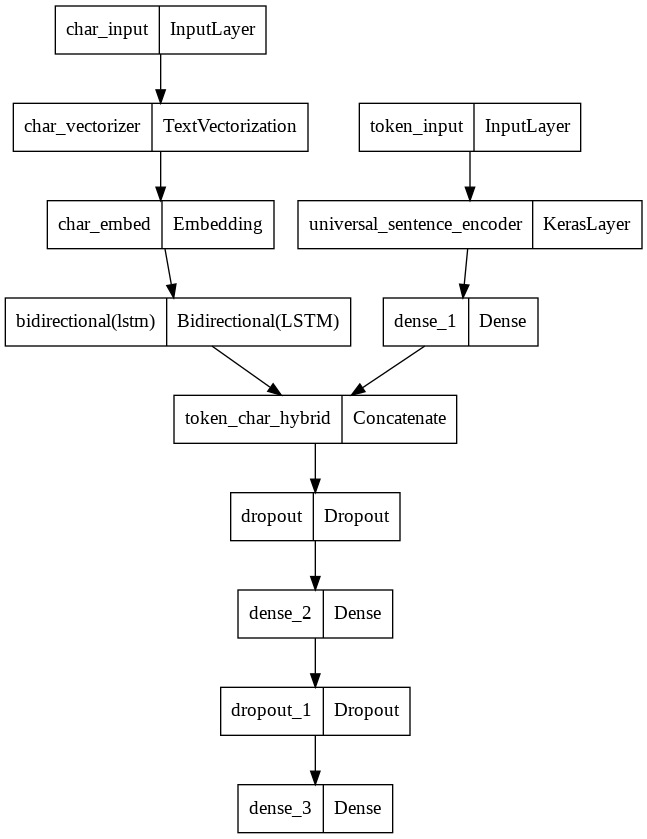

In [121]:
# Plot model_5 - hybrid token and character model
plot_model(model_5)

In [122]:
# Compile model_5
model_5.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(), # The paper used SGD optimizer
                metrics=["accuracy"])

### Combining token and character data into a `tf.data` dataset

* `((token_data, char_data), (label))`

In [124]:
# Combine chars and tokens into a dataset
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars)) # make data
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # make labels
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels)) # combine data and labels

# Prefetch and batch train data
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) 

# Repeat same steps on dev data
dev_char_token_data = tf.data.Dataset.from_tensor_slices((dev_sentences, dev_chars))
dev_char_token_labels = tf.data.Dataset.from_tensor_slices(dev_labels_one_hot)
dev_char_token_dataset = tf.data.Dataset.zip((dev_char_token_data, dev_char_token_labels))
dev_char_token_dataset = dev_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Check out training char and token embedding dataset
print(train_char_token_dataset)
print(dev_char_token_dataset)

<PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>
<PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>


In [125]:
# Fit model_5 on tokens and chars
model_5_history = model_5.fit(train_char_token_dataset, # train on dataset of token and characters
                              steps_per_epoch=int(0.2 * len(train_char_token_dataset)),
                              epochs=5,
                              validation_data=dev_char_token_dataset,
                              validation_steps=int(0.2 * len(dev_char_token_dataset)))

Epoch 1/5
1125/1125 [==============================] - 50s 37ms/step - loss: 0.8781 - accuracy: 0.6544 - val_loss: 0.7141 - val_accuracy: 0.7312
Epoch 2/5
1125/1125 [==============================] - 54s 48ms/step - loss: 0.7499 - accuracy: 0.7145 - val_loss: 0.6692 - val_accuracy: 0.7447
Epoch 3/5
1125/1125 [==============================] - 54s 48ms/step - loss: 0.7374 - accuracy: 0.7213 - val_loss: 0.6453 - val_accuracy: 0.7593
Epoch 4/5
1125/1125 [==============================] - 51s 45ms/step - loss: 0.7015 - accuracy: 0.7326 - val_loss: 0.6289 - val_accuracy: 0.7636
Epoch 5/5
1125/1125 [==============================] - 37s 33ms/step - loss: 0.6953 - accuracy: 0.7359 - val_loss: 0.6279 - val_accuracy: 0.7654


### **Model 5**: Evaluation

In [126]:
model_5.evaluate(dev_char_token_dataset)

945/945 [==============================] - 19s 21ms/step - loss: 0.6272 - accuracy: 0.7621


[0.6271920800209045, 0.7620812654495239]

### **Model 5**: Make Predictions

In [127]:
model_5_pred_probs = model_5.predict(dev_char_token_dataset)
model_5_pred_probs

array([[5.2555597e-01, 2.8833541e-01, 1.3597676e-03, 1.7850806e-01,
        6.2408219e-03],
       [4.3247405e-01, 4.4743285e-01, 1.6011911e-03, 1.1730676e-01,
        1.1851816e-03],
       [4.0851560e-01, 3.3665192e-03, 9.0841511e-03, 5.7793951e-01,
        1.0941940e-03],
       ...,
       [2.0608913e-05, 2.4644771e-04, 3.6399469e-03, 3.5048333e-06,
        9.9608946e-01],
       [8.2171885e-03, 6.5685600e-02, 1.2208194e-01, 3.0382553e-03,
        8.0097699e-01],
       [7.1251079e-02, 8.7670213e-01, 4.4787075e-02, 2.4256203e-03,
        4.8341807e-03]], dtype=float32)

In [128]:
# Convert prediction probabilities into prediction classes
model_5_preds = tf.argmax(model_5_pred_probs, axis=1)
model_5_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 1])>

### **Model 5**: Model Results (Accuracy, Precision, Recall, F1-Score)

In [129]:
# Get results of model_5
model_5_results = calculate_results(y_true=dev_labels_encoded,
                                    y_pred=model_5_preds)
model_5_results

{'accuracy': 76.20812922017741,
 'precision': 0.7573423036629349,
 'recall': 0.7620812922017741,
 'f1': 0.7569120157923535}

### **Model 6**: Transfer Learning with pretrained token embeddings + character embeddings + positional embeddings 

The `"line_number"` and `"total_lines"` columns are features which didn't necessarily come with the training data but can be passed to our model as a **positional embedding**. In other words, the positional embedding is where the sentence appears in an abstract.

Here we can use these features because they will be available at test time. 


### Create Positional Embeddings

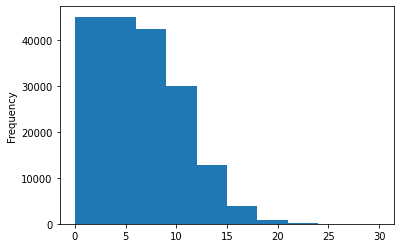

In [132]:
# Check the distribution of "line_number" column
train_df.line_number.plot.hist();
# The majority of lines have a position of 15 or less. Knowing this, let's set the `depth` parameter of `tf.one_hot` to 15.

In [133]:
# Use TensorFlow to create one-hot-encoded tensors of our "line_number" column 
train_line_numbers_one_hot = tf.one_hot(train_df["line_number"].to_numpy(), depth=15) 
dev_line_numbers_one_hot = tf.one_hot(dev_df["line_number"].to_numpy(), depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df["line_number"].to_numpy(), depth=15)

In [134]:
# Have a look on one-hot encoded `line_number`
train_line_numbers_one_hot.shape, train_line_numbers_one_hot[:10]

(TensorShape([180040, 15]), <tf.Tensor: shape=(10, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]],
       dtype=float32)>)

In [135]:
# Check the coverage of a "total_lines" value of 20
np.percentile(train_df.total_lines, 98) # a value of 20 covers 98% of samples

20.0

In [136]:
# Create one-hot-encoded tensors of `total_lines` column 
train_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(), depth=20)
dev_total_lines_one_hot = tf.one_hot(dev_df["total_lines"].to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(), depth=20)

# Check shape and samples of total lines one-hot tensor
train_total_lines_one_hot.shape, train_total_lines_one_hot[:10]

(TensorShape([180040, 20]), <tf.Tensor: shape=(10, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.

In [137]:
# Create model_6 

# 1. Token inputs
token_inputs = layers.Input(shape=[], dtype="string", name="token_inputs")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_outputs)

# 2. Char inputs
char_inputs = layers.Input(shape=(1,), dtype="string", name="char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(32))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# 3. Line numbers inputs
line_number_inputs = layers.Input(shape=(15,), dtype=tf.int32, name="line_number_input")
x = layers.Dense(32, activation="relu")(line_number_inputs)
line_number_model = tf.keras.Model(inputs=line_number_inputs,
                                   outputs=x)

# 4. Total lines inputs
total_lines_inputs = layers.Input(shape=(20,), dtype=tf.int32, name="total_lines_input")
y = layers.Dense(32, activation="relu")(total_lines_inputs)
total_line_model = tf.keras.Model(inputs=total_lines_inputs,
                                  outputs=y)

# 5. Combine token and char embeddings into a hybrid embedding
combined_embeddings = layers.Concatenate(name="token_char_hybrid_embedding")([token_model.output, 
                                                                              char_model.output])
z = layers.Dense(256, activation="relu")(combined_embeddings)
z = layers.Dropout(0.5)(z)

# 6. Combine positional embeddings with combined token and char embeddings into a tribrid embedding
z = layers.Concatenate(name="token_char_positional_embedding")([line_number_model.output,
                                                                total_line_model.output,
                                                                z])

# 7. Create output layer
output_layer = layers.Dense(5, activation="softmax", name="output_layer")(z)

# 8. Put together model
model_6 = tf.keras.Model(inputs=[line_number_model.input,
                                 total_line_model.input,
                                 token_model.input, 
                                 char_model.input],
                                 outputs=output_layer)

In [138]:
# Get model_6 summary
model_6.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_inputs (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 token_inputs (InputLayer)      [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_inputs[0][0]']            
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   ['token_inputs[0][0]']     

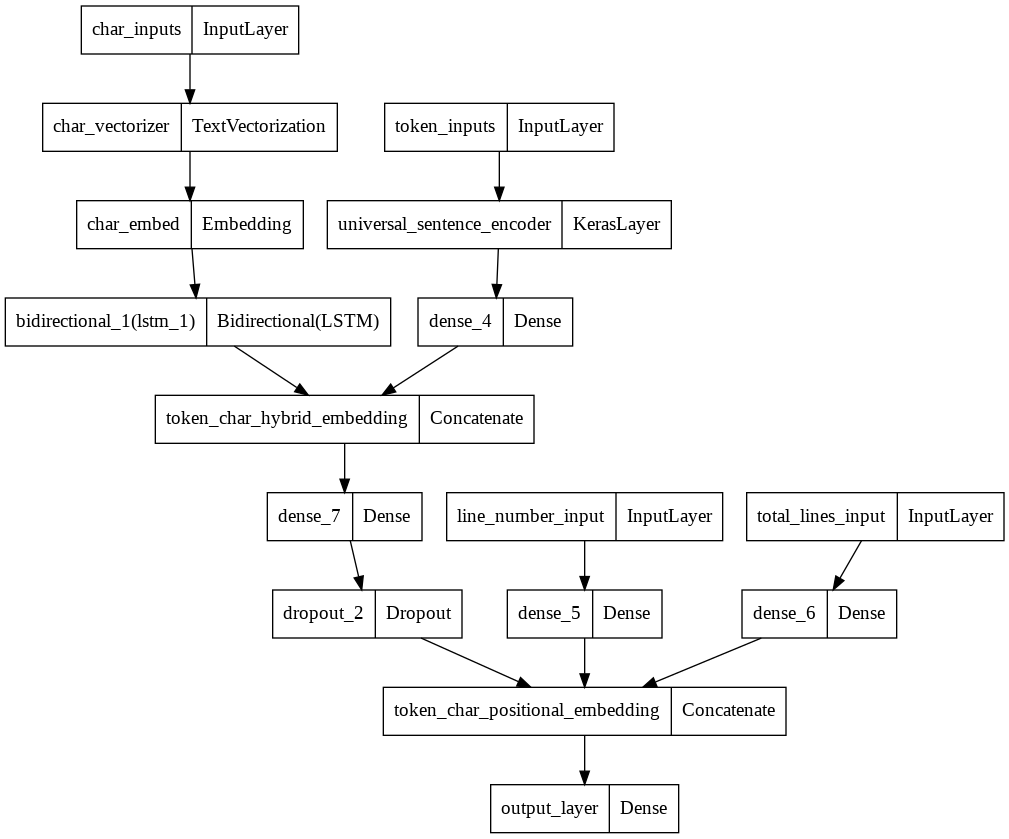

In [139]:
# Plot model_6 
plot_model(model_6)

In [140]:
# Compile model_6 - token, char, positional embedding model
model_6.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2), # to prevent overfitting
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [141]:
# Create training and dev datasets (all four kinds of inputs)
train_pos_char_token_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot, # line numbers
                                                                train_total_lines_one_hot, # total lines
                                                                train_sentences, # train tokens
                                                                train_chars)) # train chars


train_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # train labels
train_pos_char_token_dataset = tf.data.Dataset.zip((train_pos_char_token_data, train_pos_char_token_labels)) # combine data and labels
train_pos_char_token_dataset = train_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # turn into batches and prefetch appropriately

# Dev dataset
dev_pos_char_token_data = tf.data.Dataset.from_tensor_slices((dev_line_numbers_one_hot,
                                                              dev_total_lines_one_hot,
                                                              dev_sentences,
                                                              dev_chars))
dev_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(dev_labels_one_hot)
dev_pos_char_token_dataset = tf.data.Dataset.zip((dev_pos_char_token_data, dev_pos_char_token_labels))
dev_pos_char_token_dataset = dev_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) 

# Check input shapes
train_pos_char_token_dataset, dev_pos_char_token_dataset

(<PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [142]:
# Fit the model 
model_6_history = model_6.fit(train_pos_char_token_dataset,
                              steps_per_epoch=int(0.2 * len(train_pos_char_token_dataset)), 
                              epochs=5,
                              validation_data=dev_pos_char_token_dataset,
                              validation_steps=int(0.2 * len(dev_pos_char_token_dataset))) 

Epoch 1/5
1125/1125 [==============================] - 56s 46ms/step - loss: 1.0334 - accuracy: 0.7681 - val_loss: 0.9447 - val_accuracy: 0.8292
Epoch 2/5
1125/1125 [==============================] - 47s 42ms/step - loss: 0.9439 - accuracy: 0.8297 - val_loss: 0.9249 - val_accuracy: 0.8381
Epoch 3/5
1125/1125 [==============================] - 51s 45ms/step - loss: 0.9376 - accuracy: 0.8341 - val_loss: 0.9137 - val_accuracy: 0.8469
Epoch 4/5
1125/1125 [==============================] - 57s 50ms/step - loss: 0.9245 - accuracy: 0.8446 - val_loss: 0.9033 - val_accuracy: 0.8576
Epoch 5/5
1125/1125 [==============================] - 43s 38ms/step - loss: 0.9227 - accuracy: 0.8441 - val_loss: 0.9045 - val_accuracy: 0.8525


### **Model 6**: Evaluation

In [143]:
model_6.evaluate(dev_pos_char_token_dataset)

945/945 [==============================] - 21s 22ms/step - loss: 0.9075 - accuracy: 0.8488


[0.9075400233268738, 0.8487687110900879]

### **Model 6**: Make Predictions

In [144]:
# Make predictions with token-char-positional hybrid model
model_6_pred_probs = model_6.predict(dev_pos_char_token_dataset, verbose=1)
model_6_pred_probs

945/945 [==============================] - 21s 21ms/step


array([[0.57478786, 0.09835552, 0.01908468, 0.27859223, 0.02917967],
       [0.5510551 , 0.10804772, 0.09335528, 0.22376731, 0.02377465],
       [0.33541736, 0.08534675, 0.05311083, 0.47772226, 0.04840276],
       ...,
       [0.02001557, 0.06144512, 0.01538897, 0.02669715, 0.8764532 ],
       [0.01771179, 0.2790848 , 0.05109637, 0.02034378, 0.6317632 ],
       [0.06980937, 0.8319739 , 0.04333187, 0.02673284, 0.02815208]],
      dtype=float32)

In [145]:
# Convert prediction probabilities into prediction classes
model_6_preds = tf.argmax(model_6_pred_probs, axis=1)
model_6_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

### **Model 6**: Model Results (Accuracy, Precision, Recall, F1-Score)

In [146]:
# Calculate results of token-char-positional hybrid model
model_6_results = calculate_results(y_true=dev_labels_encoded,
                                    y_pred=model_6_preds)
model_6_results

{'accuracy': 84.87687011783397,
 'precision': 0.8490030646186609,
 'recall': 0.8487687011783397,
 'f1': 0.8462264021882265}

### Compare Model Results

In [180]:
# Combine model results into a DataFrame
all_model_results = pd.DataFrame({"TF-IDF Multinomial Naive Bayes (baseline)": baseline_results,
                                  "TF-IDF Linear Support Vector Classification (SVC)": model_1_results,
                                  "Conv1D with Token Embeddings": model_2_results,
                                  "Feature Extraction with Pretrained Token Embeddings": model_3_results,
                                  "Conv1D with Character Embeddings": model_4_results,
                                  "Hybrid Embedding Layer": model_5_results,
                                  "Tribrid Pos Char Token Embeddings": model_6_results})

all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
TF-IDF Multinomial Naive Bayes (baseline),72.183238,0.718647,0.721832,0.698925
TF-IDF Linear Support Vector Classification (SVC),78.882563,0.784429,0.788826,0.785652
Conv1D with Token Embeddings,80.951278,0.806536,0.809513,0.805778
Feature Extraction with Pretrained Token Embeddings,75.188667,0.747089,0.751887,0.746964
Conv1D with Character Embeddings,70.336290,0.695976,0.703363,0.694213
Hybrid Embedding Layer,76.208129,0.757342,0.762081,0.756912
Tribrid Pos Char Token Embeddings,84.876870,0.849003,0.848769,0.846226


In [181]:
# Reduce the accuracy to same scale as other metrics
all_model_results["accuracy"] = all_model_results["accuracy"]/100

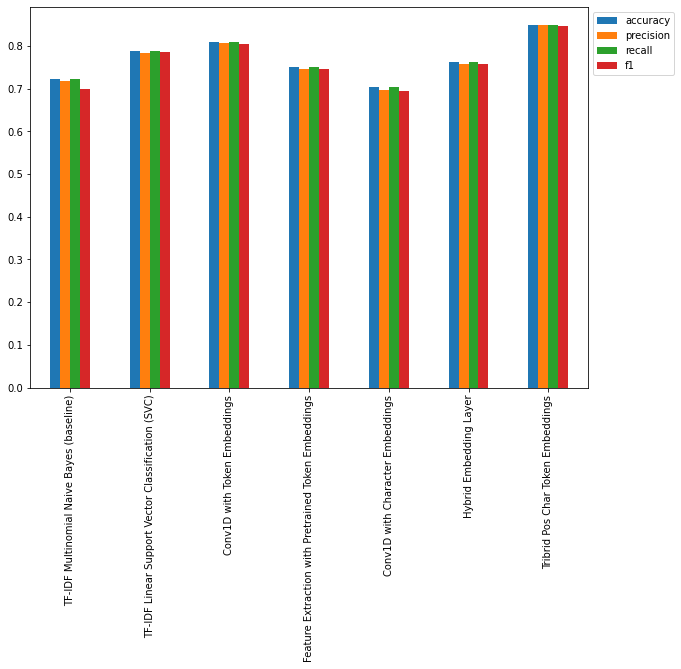

In [182]:
# Plot and compare all of the model results
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));

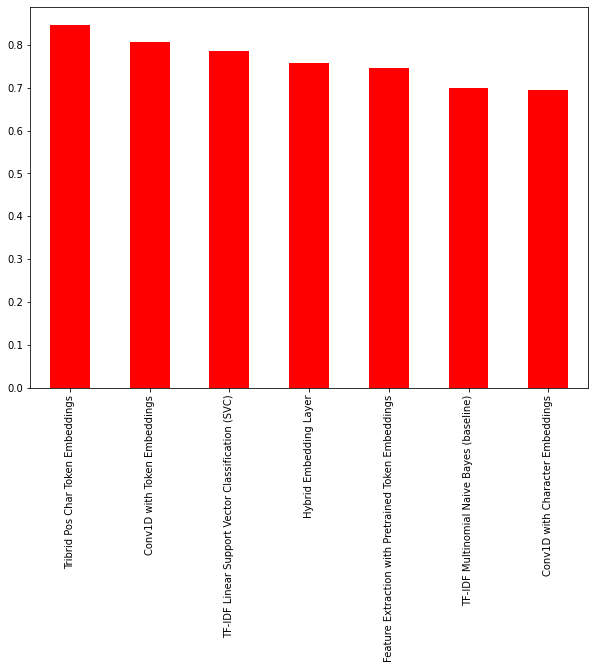

In [184]:
# Sort model results by F1-Score
all_model_results.sort_values("f1", ascending=False)["f1"].plot(kind="bar",color="red", figsize=(10, 7));

In [185]:
# Save best performing model to SavedModel format (default)
model_6.save("skimlit_tribrid_model")

### References: 

* [Dataset Source - PubMed 200k RCT dataset](https://github.com/Franck-Dernoncourt/pubmed-rct)

* [PubMed 200k RCT: a Dataset for Sequential Sentence Classification in Medical Abstracts](https://arxiv.org/abs/1710.06071)

* [Neural Networks for Joint Sentence Classification
in Medical Paper Abstracts](https://arxiv.org/pdf/1612.05251.pdf)

* [TfidfVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html)

* [Scikit-Learn Documentation](https://scikit-learn.org/stable/)

* [Linear Support Vector Classification (SVC)](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html)

* [tf.data: Build TensorFlow input pipelines](https://www.tensorflow.org/guide/data)

* [Better performance with the tf.data API](https://www.tensorflow.org/guide/data_performance)

* [Label smoothing with Keras, TensorFlow, and Deep Learning](https://www.pyimagesearch.com/2019/12/30/label-smoothing-with-keras-tensorflow-and-deep-learning/).










